# **1.Import Libraries**

In [142]:
! pip install Wikipedia-API
import wikipediaapi
import pandas as pd
import wikipediaapi
import math
import json
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score,confusion_matrix

from imblearn.combine import SMOTETomek

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# **2.Clean Dataset**

In [143]:
dataset=pd.read_csv('/content/drive/MyDrive/Datasets/final_wiki_data.csv')
dataset.head()

,Title,Article Name,Summary,Full Text,Links,Sections,Categories,Class
0,Mario Luigi Ciappi,Mario_Luigi_Ciappi,"Mario Luigi Ciappi, O.P. (6 October 1909 ? 23 ...","Mario Luigi Ciappi, O.P. (6 October 1909 ? 23 ...","['Aesthetics', 'Alma mater', 'Angelo Verardo',...",7,"['1909 births', '1996 deaths', '20th-century I...",Start
1,Galactik Football,Rocket_(Galactik_Football),Galactik Football is an animated television se...,Galactik Football is an animated television se...,"['101 Dalmatian Street', '2D animation', '3D c...",7,"['2000s French animated television series', '2...",NaN
2,Whitehorse Centre,Whitehorse_Centre,Whitehorse Centre is an electoral district whi...,Whitehorse Centre is an electoral district whi...,"['1992 Yukon general election', '1996 Yukon ge...",3,"['All articles needing additional references',...",Start
3,Propebela harpularia,Propebela_harpularia,Propebela harpularia is a species of sea snail...,Propebela harpularia is a species of sea snail...,"['Animal', 'Binomial nomenclature', 'Body whor...",4,"[""Articles with 'species' microformats"", 'Arti...",Stub
4,Acacia drummondii,Acacia_drummondii,"Acacia drummondii, commonly known as Drummond'...","Acacia drummondii, commonly known as Drummond'...","['Acacia', 'Albany, Western Australia', 'Austr...",4,"['Acacia', 'Acacias of Western Australia', ""Ar...",Start


In [144]:
print(dataset.shape)

(10963, 8)


In [145]:
#It's better to work on a copy of the dataset rather than modifying the original dataset.
df = dataset.copy()
df.shape

(10963, 8)

In [146]:
df.isnull().sum()

,0
Title,0
Article Name,2
Summary,2229
Full Text,2229
Links,0
Sections,0
Categories,0
Class,2969


In [147]:
df.dropna(subset=['Class'], inplace=True)

In [148]:
df['Class'].value_counts()

,count
Class,
Stub,4061
Start,2181
FA,968
C,326
List,288
B,135
GA,33
A,2


Although the "Summary" and "Full Text" columns contain null values, I believe we should retain them as they may hold valuable information.

The "Class" column is our dependent variable, and with more than 30% of the data missing, we need to carefully consider how to handle it.

In [149]:
df.duplicated().sum()

0

In [151]:
df = df.drop_duplicates()

In [107]:
duplicates = df[df.duplicated()]  # Get duplicate rows (based on all columns)
duplicate_count = duplicates.shape[0]  # Count duplicate rows

# Print results
print(f"Number of duplicate rows: {duplicate_count}")
if duplicate_count > 0:
    print("Duplicate rows:")
    print(duplicates)

Number of duplicate rows: 0


In [152]:
df.isnull().sum()

,0
Title,0
Article Name,0
Summary,1647
Full Text,1647
Links,0
Sections,0
Categories,0
Class,0


In [153]:
df.shape
class_counts = df['Class'].value_counts()
class_counts

,count
Class,
Stub,4061
Start,2181
FA,968
C,326
List,288
B,135
GA,33
A,2


In [154]:
df.rename(
    columns=({ 'Full Text': 'Full_Text'}),
    inplace=True,)


In [155]:
df.dtypes

,0
Title,object
Article Name,object
Summary,object
Full_Text,object
Links,object
Sections,int64
Categories,object
Class,object


Since the "Sections" column is of object type, we need to convert it to an integer type.

In [156]:
df['Sections'] = pd.to_numeric(df['Sections'], errors='coerce').fillna(0).astype(int)

# **3. Encoding**

I attempted to check if the Title and Article name are present in the Full Text, but after adjusting the threshold, I consistently got values of 1 or 0. As they didn't provide valuable insights, I decided to remove these columns.

In [157]:
df.drop(['Title', 'Article Name'], inplace=True, axis=1)

In [158]:
df

,Summary,Full_Text,Links,Sections,Categories,Class
0,"Mario Luigi Ciappi, O.P. (6 October 1909 ? 23 ...","Mario Luigi Ciappi, O.P. (6 October 1909 ? 23 ...","['Aesthetics', 'Alma mater', 'Angelo Verardo',...",7,"['1909 births', '1996 deaths', '20th-century I...",Start
2,Whitehorse Centre is an electoral district whi...,Whitehorse Centre is an electoral district whi...,"['1992 Yukon general election', '1996 Yukon ge...",3,"['All articles needing additional references',...",Start
3,Propebela harpularia is a species of sea snail...,Propebela harpularia is a species of sea snail...,"['Animal', 'Binomial nomenclature', 'Body whor...",4,"[""Articles with 'species' microformats"", 'Arti...",Stub
4,"Acacia drummondii, commonly known as Drummond'...","Acacia drummondii, commonly known as Drummond'...","['Acacia', 'Albany, Western Australia', 'Austr...",4,"['Acacia', 'Acacias of Western Australia', ""Ar...",Start
6,The Association of Drainage Authorities (ADA) ...,The Association of Drainage Authorities (ADA) ...,"['2007 United Kingdom floods', 'Audit Commissi...",8,"['Articles with short description', 'Organisat...",B
...,...,...,...,...,...,...
10958,NaN,NaN,[],0,[],FA
10959,NaN,NaN,[],0,[],FA
10960,NaN,NaN,[],0,[],FA
10961,NaN,NaN,[],0,[],FA


**2. Since the "Summary" and "Full Text" columns contain text data, we are converting them into the length of the text.**

In [159]:
df['Summary_Length'] = df['Summary'].str.len()
df['Full_Text_length'] = df['Full_Text'].str.len()
df.drop(['Full_Text', 'Summary'], inplace=True, axis=1)

**3. Since the "Links" column contains a number of links in string format, separated by commas, we will count the links and store the count in a new column.**

In [160]:
df['Links_Count'] = df['Links'].str.count(',') + 1
df.drop('Links', inplace=True, axis=1)

**3. Since the "Categories" column contains a number of categories in string format, separated by commas, we will count them and store the count in a new column called "Categories_count."**

In [161]:
df['Categories_count'] = df['Categories'].str.count(',') + 1
df.drop('Categories', inplace=True, axis=1)
df

,Sections,Class,Summary_Length,Full_Text_length,Links_Count,Categories_count
0,7,Start,222.0,3145.0,85,15
2,3,Start,721.0,909.0,97,10
3,4,Stub,354.0,1649.0,37,8
4,4,Start,106.0,1560.0,54,10
6,8,B,529.0,5363.0,30,7
...,...,...,...,...,...,...
10958,0,FA,NaN,NaN,1,1
10959,0,FA,NaN,NaN,1,1
10960,0,FA,NaN,NaN,1,1
10961,0,FA,NaN,NaN,1,1


# **4.EDA**

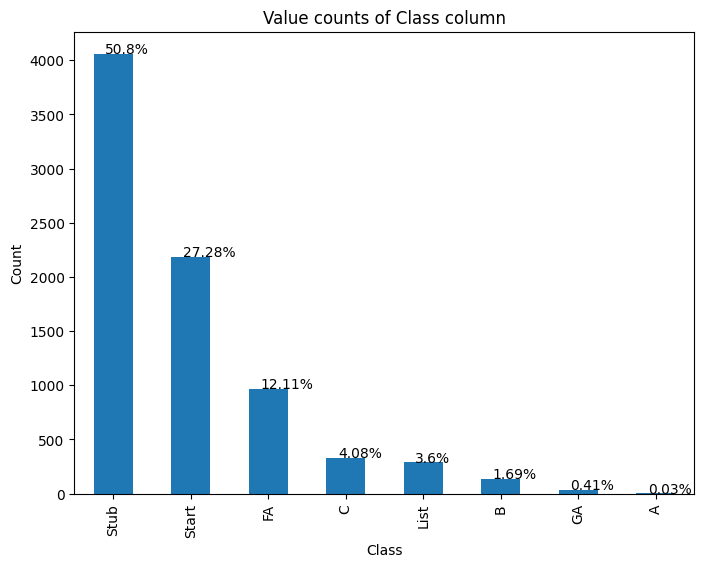

In [162]:
import matplotlib.pyplot as plt
#Get value counts of 'Class' column
class_counts = df['Class'].value_counts()

# calculate percentages
total = sum(class_counts)
percentages = [(count/total)*100 for count in class_counts]

#Plot bar chart
plt.figure(figsize=(8,6))
ax = class_counts.plot(kind='bar')
plt.title('Value counts of Class column')
plt.xlabel('Class')
plt.ylabel('Count')

#Add percentage labels
for i, v in enumerate(class_counts):
  ax.text(i-0.1, v+5, str(round(percentages[i], 2))+'%', color='black', fontsize=10)

plt.show()

In [163]:
df.Class.unique()

array(['Start', 'Stub', 'B', 'List', 'C', 'GA', 'FA', 'A'], dtype=object)

In [164]:
df['Class_Binary'] = (df['Class'] == 'FA').astype(int)
df.drop('Class', inplace=True, axis=1)

In [165]:
df.isnull().sum()

,0
Sections,0
Summary_Length,1647
Full_Text_length,1647
Links_Count,0
Categories_count,0
Class_Binary,0


In [166]:
df = df.dropna(subset = ['Summary_Length', 'Full_Text_length'])

In [167]:
df

,Sections,Summary_Length,Full_Text_length,Links_Count,Categories_count,Class_Binary
0,7,222.0,3145.0,85,15,0
2,3,721.0,909.0,97,10,0
3,4,354.0,1649.0,37,8,0
4,4,106.0,1560.0,54,10,0
6,8,529.0,5363.0,30,7,0
...,...,...,...,...,...,...
10881,7,34.0,5277.0,93,6,1
10900,5,946.0,5283.0,276,11,1
10905,14,43.0,6360.0,137,4,1
10924,8,1883.0,18419.0,150,14,1


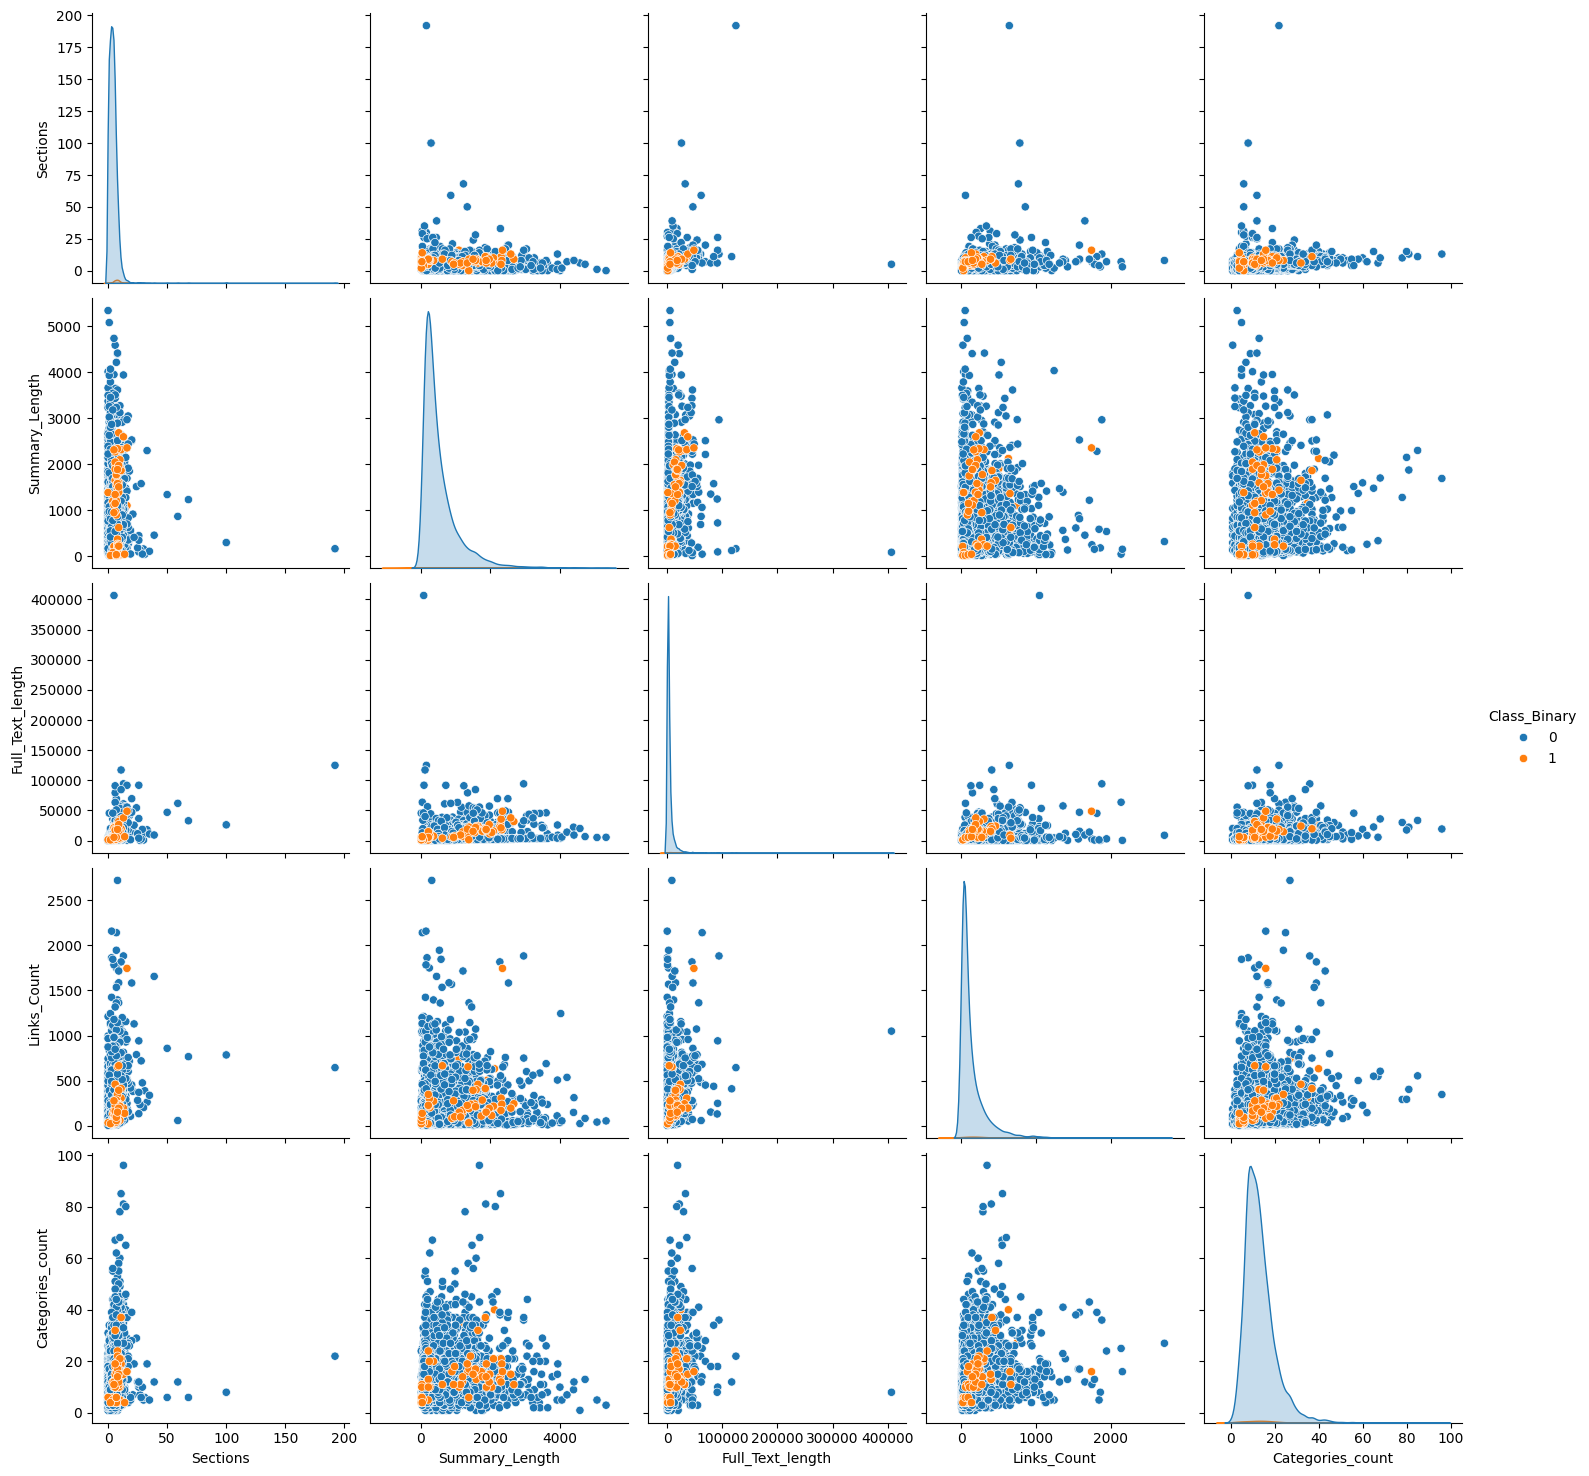

In [168]:
sns.pairplot(df, hue = 'Class_Binary', height=3)

# **5.Split dataset**

Separate the dependent and independent features.

In [169]:
X = df.drop(['Class_Binary'], axis=1)
y = df['Class_Binary']

Split data into train and test data

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

**Scaling**

In [171]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**SMOTE**

In [172]:
smote_tomek = SMOTETomek(sampling_strategy=0.75)


X_resampled, y_resampled  = smote_tomek.fit_resample(X, y)

# Checking the class distribution of the resampled data
print(y_resampled .value_counts())

Class_Binary
0    6221
1    4650
Name: count, dtype: int64


# **6.Models**

**1.Logistic Regression Model**

In [173]:
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train, y_train)
test_predicted=lr_model.predict(X_test)
train_predicted=lr_model.predict(X_train)

print()
print()
print ("The accuracy of Logistic Regression on training data : ", accuracy_score(y_train, train_predicted)*100, "%")
print ("The accuracy of Logistic Regression on testing data : ", accuracy_score(y_test, test_predicted)*100, "%")
print ("The aurroc_auc_score of Logistic Regression is : ", roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1]))




The accuracy of Logistic Regression on training data :  98.91815616180621 %
The accuracy of Logistic Regression on testing data :  99.0453460620525 %
The aurroc_auc_score of Logistic Regression is :  0.7388327181297812


**1. Logistic Regression with SMOTE Sampling Technique**

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled , test_size=0.33, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr_model = LogisticRegression(max_iter=100)
lr_model.fit(X_train, y_train)
train_predicted=lr_model.predict(X_train)
test_predicted=lr_model.predict(X_test)
print()
print()

print ("The accuracy of Logistic Regression on training data : ", accuracy_score(y_train, train_predicted)*100, "%")
print ("The accuracy of Logistic Regression on testing data : ", accuracy_score(y_test, test_predicted)*100, "%")
print ("The aurroc_auc_score of Logistic Regression is : ", roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1]))





The accuracy of Logistic Regression on training data :  79.69243443635864 %
The accuracy of Logistic Regression on testing data :  79.15273132664437 %
The aurroc_auc_score of Logistic Regression is :  0.8989751941909097


**2.Random Forest**

In [175]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
predicted_train = rf_model.predict(X_train)  # Predictions for training data
predicted_test = rf_model.predict(X_test)   # Predictions for testing data

# Evaluate and print results
print(f"The accuracy of Random Forest on training dataset: {accuracy_score(y_train, predicted_train) * 100:.2f}%")
print(f"The accuracy of Random Forest on testing dataset: {accuracy_score(y_test, predicted_test) * 100:.2f}%")
print()
print(f"The ROC AUC score of Random Forest is: {roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]):.4f}")

The accuracy of Random Forest on training dataset: 99.99%
The accuracy of Random Forest on testing dataset: 98.38%

The ROC AUC score of Random Forest is: 0.9988


**2.1. Random Forest with SMOTE**

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled , test_size=0.33, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

rf_model.fit(X_train, y_train)

predicted_train = rf_model.predict(X_train)
predicted_test = rf_model.predict(X_test)


print("The accuracy of Random Forest on training dataset : ", accuracy_score(y_train, predicted_train.round())*100, "%")
print("The accuracy of Random Forest on testing dataset : ", accuracy_score(y_test, predicted_test.round())*100, "%")
print()
print ("The aurroc_auc_score of  random forest is : ", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))

The accuracy of Random Forest on training dataset :  99.9862693944803 %
The accuracy of Random Forest on testing dataset :  98.38350055741361 %

The aurroc_auc_score of  random forest is :  0.9987578786822242


**3. SVC Model**

In [177]:
svm_model = SVC(kernel='rbf', probability=True)

svm_model.fit(X_train, y_train)

predicted_train = svm_model.predict(X_train)
predicted_test = svm_model.predict(X_test)

print("The accuracy of SVM on training dataset : ", accuracy_score(y_train, predicted_train)*100, "%")
print("The accuracy of SVM on testing dataset : ", accuracy_score(y_test, predicted_test)*100, "%")
print()
print("The aucroc score of SVM is : ", roc_auc_score(y_test, svm_model.predict_proba(X_test)[:, 1]))


The accuracy of SVM on training dataset :  94.94713716874914 %
The accuracy of SVM on testing dataset :  93.95206243032331 %

The aucroc score of SVM is :  0.9802480103292528


**SVC Model with SMOTE**

In [178]:
# Split the dataset into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Support Vector Machine classifier
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

# Predict the labels of the test dataset
y_pred_test = svm_model.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred_test)
print("The accuracy of SVM on the testing dataset:", accuracy)

# Calculate the AUC score of the classifier
y_prob_test = svm_model.decision_function(X_test)
auc_score = roc_auc_score(y_test, y_prob_test)
print("The AUC score of SVM on the testing dataset:", auc_score)


The accuracy of SVM on the testing dataset: 0.8037904124860646
The AUC score of SVM on the testing dataset: 0.9064403401266321


**Oberservation**

Using the SMOTE strategy results in a decrease in accuracy, whereas without SMOTE, the accuracy increases.

# **Post Evalustion**

**1. What’s the accuracy you are getting?**

The highest accuracy is achieved with the Random Forest Classifier at 99.38%

followed by Logistic Regression at 99.04%,

and SVM at 93.95%.

**2.What if i choose SVM instead of logistic regression?**

As per accuracy and auroc score SVM performing better than logistic regression

**3. What features do you think are important? Can you get the same accuracy using only a single feature?**

**Feature Importance**

<Axes: >

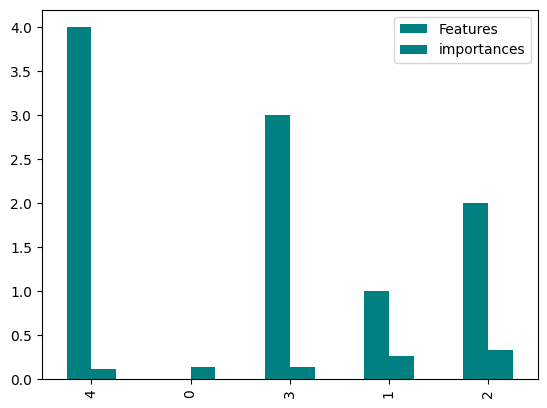

In [179]:
importances = rf_model.feature_importances_
df1 = pd.DataFrame({"Features":pd.DataFrame(X_test).columns,"importances":importances})
df1.set_index("importances")

df1 = df1.sort_values('importances')
df1.plot.bar(color='teal')

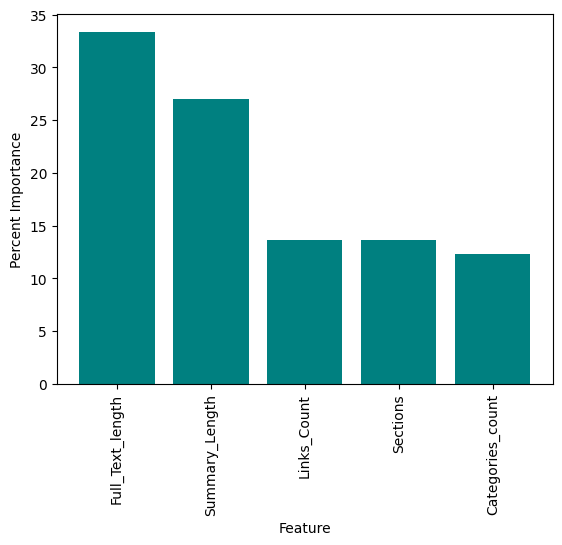

In [180]:
df2=df.drop('Class_Binary',axis=1)
feature_names = list(df2.columns)
if 'y' in feature_names:
    feature_names.remove('y')
total_importance = importances.sum()
percent_importances = importances / total_importance * 100

# DataFrame with the feature names and their percent importances
df2 = pd.DataFrame({'feature_names': feature_names, 'percent_importances': percent_importances})

# Sort the DataFrame
df2 = df2.sort_values(by='percent_importances', ascending=False)

#bar plot of the percent importances
plt.bar(x=df2['feature_names'], height=df2['percent_importances'], color='teal')
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Percent Importance')
plt.show()


**When we use the most important feature as the sole independent variable**

In [181]:
X_new = X['Full_Text_length'].values.reshape(-1, 1)
y_new= y
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.33, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

rf_model.fit(X_train, y_train)

predicted_train = rf_model.predict(X_train)
predicted_test = rf_model.predict(X_test)

print("The accuracy of Random Forest on training dataset : ", accuracy_score(y_train, predicted_train.round())*100, "%")
print("The accuracy of Random Forest on testing dataset : ", accuracy_score(y_test, predicted_test.round())*100, "%")
print()
print ("The aurroc_auc_score of  random forest is : ", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))

The accuracy of Random Forest on training dataset :  99.8824082784572 %
The accuracy of Random Forest on testing dataset :  98.28162291169451 %

The aurroc_auc_score of  random forest is :  0.5888166693414648


**We get slightly less accuracy, which indicates that other features are also important for the model's prediction.**